<h1> Soft Actor Critic Demystified</h1>
<h4> By Vaishak Kumar </h4>
<br>
<a href="https://arxiv.org/pdf/1801.01290.pdf">Original Paper</a>
<br> 
<a href="https://github.com/higgsfield/RL-Adventure-2">Adapted from higgsfield's implementation</a>

In [ ]:
import math
import random
from big2Game import vectorizedBig2Games
import random
import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display

%matplotlib inline

use_cuda = torch.cuda.is_available()
device   = torch.device('cpu')

<h2>Auxilliary Functions</h2>

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

In [ ]:
class NormalizedActions(gym.ActionWrapper):
    def action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        
        action = low + (action + 1.0) * 0.5 * (high - low)
        action = np.clip(action, low, high)
        
        return action

    def _reverse_action(self, action):
        low  = self.action_space.low
        high = self.action_space.highnum_inputs, num_actions, 
        
        action = 2 * (action - low) / (high - low) - 1
        action = np.clip(action, low, high)
        
        return actions

In [ ]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()

<h1>Network Definitions</h1>

In [ ]:
class ValueNetwork(nn.Module):
    def __init__(self, state_dim, hidden_dim, init_w=3e-3):
        super(ValueNetwork, self).__init__()
        
        self.linear1 = nn.Linear(state_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
        
        
class SoftQNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(SoftQNetwork, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        # print('num inputs0,')
        # print('state shape', state.shape, 'action shape', action.shape)
        # print('x.shape', x.shape)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
        
        
class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3, log_std_min=-20, log_std_max=2):
        super(PolicyNetwork, self).__init__()
        
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        
        self.mean_linear = nn.Linear(hidden_size, num_actions)
        self.mean_linear.weight.data.uniform_(-init_w, init_w)
        self.mean_linear.bias.data.uniform_(-init_w, init_w)
        
        self.log_std_linear = nn.Linear(hidden_size, num_actions)
        self.log_std_linear.weight.data.uniform_(-init_w, init_w)
        self.log_std_linear.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        
        mean    = self.mean_linear(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        
        return mean, log_std
    
    def evaluate(self, state, epsilon=1e-6):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        normal = Normal(0, 1)
        z      = normal.sample()
        action = torch.tanh(mean+ std*z.to(device))
        log_prob = Normal(mean, std).log_prob(mean+ std*z.to(device)) - torch.log(1 - action.pow(2) + epsilon)
        return action, log_prob, z, mean, log_std
        
    
    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        normal = Normal(0, 1)
        z      = normal.sample().to(device)
        action = torch.tanh(mean + std*z)
        
        action  = action.cpu()#.detach().cpu().numpy()
        return action[0]

<h1> Update Function </h1>

In [ ]:
def update(batch_size,gamma=0.99,soft_tau=1e-2,):
    
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = torch.FloatTensor(state).to(device)
    next_state = torch.FloatTensor(next_state).to(device)
    action     = torch.FloatTensor(action).to(device)
    reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
    done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)

    predicted_q_value1 = soft_q_net1(state, action)
    predicted_q_value2 = soft_q_net2(state, action)
    predicted_value    = value_net(state)
    new_action, log_prob, epsilon, mean, log_std = policy_net.evaluate(state)

    
    
# Training Q Function
    target_value = target_value_net(next_state)
    target_q_value = reward + (1 - done) * gamma * target_value
    q_value_loss1 = soft_q_criterion1(predicted_q_value1, target_q_value.detach())
    q_value_loss2 = soft_q_criterion2(predicted_q_value2, target_q_value.detach())


    soft_q_optimizer1.zero_grad()
    q_value_loss1.backward()
    soft_q_optimizer1.step()
    soft_q_optimizer2.zero_grad()
    q_value_loss2.backward()
    soft_q_optimizer2.step()    
# Training Value Function
    predicted_new_q_value = torch.min(soft_q_net1(state, new_action),soft_q_net2(state, new_action))
    target_value_func = predicted_new_q_value - log_prob
    value_loss = value_criterion(predicted_value, target_value_func.detach())

    
    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()
# Training Policy Function
    policy_loss = (log_prob - predicted_new_q_value).mean()

    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()
    
    
    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
        target_param.data.copy_(
            target_param.data * (1.0 - soft_tau) + param.data * soft_tau
        )

<h2> Initializations </h2>

In [ ]:
nGames = 1
env = vectorizedBig2Games(nGames)

action_dim = 1695 # env.action_space.shape[0]
state_dim  = 412 #env.observation_space.shape[0]
hidden_dim = 256

value_net        = ValueNetwork(state_dim, hidden_dim).to(device)
target_value_net = ValueNetwork(state_dim, hidden_dim).to(device)

soft_q_net1 = SoftQNetwork(state_dim, action_dim, hidden_dim).to(device)
soft_q_net2 = SoftQNetwork(state_dim, action_dim, hidden_dim).to(device)
policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)
    

value_criterion  = nn.MSELoss()
soft_q_criterion1 = nn.MSELoss()
soft_q_criterion2 = nn.MSELoss()

value_lr  = 3e-4
soft_q_lr = 3e-4
policy_lr = 3e-4

value_optimizer  = optim.Adam(value_net.parameters(), lr=value_lr)
soft_q_optimizer1 = optim.Adam(soft_q_net1.parameters(), lr=soft_q_lr)
soft_q_optimizer2 = optim.Adam(soft_q_net2.parameters(), lr=soft_q_lr)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)


replay_buffer_size = 1000000
replay_buffer = ReplayBuffer(replay_buffer_size)

# Training Hyperparameters

In [ ]:
max_frames  = 40000
max_steps   = 500
frame_idx   = 0
rewards     = []
batch_size  = 128

# Training Loop

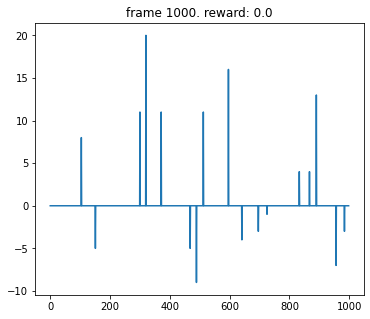

Process Process-5:
Traceback (most recent call last):
  File "/home/yosua/anaconda3/envs/fp_cs5446/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/yosua/anaconda3/envs/fp_cs5446/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/yosua/Documents/Projects/big2/big2Game.py", line 533, in worker
    reward, done, info = game.step(data)
  File "/home/yosua/Documents/Projects/big2/big2Game.py", line 507, in step
    opt, nC = enumerateOptions.getOptionNC(action)
  File "/home/yosua/Documents/Projects/big2/enumerateOptions.py", line 23, in getOptionNC
    if ind == passInd:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


a 1694 , r  0.0


EOFError: 

In [45]:

from math import inf
while frame_idx < max_frames:
    [playerTurn, state, availableActions] = env.getCurrStates()
    episode_reward = 0
    
    for step in range(max_steps):
        
        ## Run action for player 1
        player1_reward = 0
        # if frame_idx >1000:
            [playerTurn, state, availableActions] = env.getCurrStates()
            action = policy_net.get_action(state).detach().numpy()[0]
            action = np.add(action, availableActions)
            actoin = action.argmax()
            reward, done, next_state = env.step([action])  
            # print('action taken', action)

            player1_reward += np.array(reward).squeeze()[0]
            # print('reward', player1_reward)

        else:
            # action = env.action_space.sample()
            action = random.randint(0,action_dim-1)
          
            while availableActions[0,0,action] == -inf:
                action =  random.randint(0,action_dim-1)
                
            # print('action taken random', action)
            # print('availableActions', availableActions[0,0,action])
            reward, done, next_state = env.step([action])

            player1_reward += np.array(reward).squeeze()[0]
            # print('reward', player1_reward)

        print('a', action, ', r ', player1_reward)
        
        # print('pushing to buffer', state, action, reward, next_state, done)
        # print('pushing to buffer', np.array(state.shape), action,player1_reward, np.array(next_state).shape, np.array(done).shape)
        # pushing to buffer [  1   1 412] () (1,) (1, 4) (1, 3)
        # print('next_state', next_state)
        state = state.squeeze()
        next_state = np.array(next_state).squeeze()
        action = [action]
        done = done[0]
        # print('pushing to buffer after shape', np.array(state).shape, action,player1_reward, np.array(next_state).shape, done)


        # try one hot encoding the action space
        action_one_hot = np.zeros(action_dim)
        action_one_hot[action] = 1
        action = action_one_hot
        # print('one hot encode action', action)
        # action = np.zeros(action_dim)[action] = 1 
        replay_buffer.push(state, action, player1_reward, next_state, done)
# pushing to buffer [ 0.29733867 -0.95477208 -0.69822459] [-1.6809958] -1.6628393972491333 [ 0.21450876 -0.97672206 -1.71430365] False
# pushing to buffer after shape [412] [7] 0.0 (1, 1, 412) (1,)

        ### Run action for player 2 - 4
        ### The problem is that it doesnt take into acount the available actions
        for player in range(1, 3):
            [playerTurn, state, availableActions] = env.getCurrStates()
            action = policy_net.get_action(state).detach().numpy()[0]
            action1 = action
            action = np.add(action, availableActions)
            action2 = action
            action = action[0,0,:].argmax()
            # print('action taken opponent', action)
            reward, done, next_state = env.step([action])            
        
        state = next_state
        episode_reward += player1_reward
        frame_idx += 1
        
        if len(replay_buffer) > batch_size:
            update(batch_size)
            print('updating params')
        
        if frame_idx % 1000 == 0:
            plot(frame_idx, rewards)
        
        if done:
            break
        
    rewards.append(episode_reward)

<h2> Visualize Trained Algorithm </h2> - <a href="http://mckinziebrandon.me/TensorflowNotebooks/2016/12/21/openai.html">source</a>  

In [ ]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(anim)

In [ ]:
env = gym.make("Pendulum-v0")

# Run a demo of the environment
state = env.reset()
cum_reward = 0
frames = []
for t in range(50000):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    action = policy_net.get_action(state)
    state, reward, done, info = env.step(action.detach())
    if done:
        break
env.close()
display_frames_as_gif(frames)



AttributeError: 'ImageData' object has no attribute 'data'